RUN

In [1]:
#  verifying if gpu is attached
!nvidia-smi -L
!nvidia-smi --query-gpu=name,memory.total --format=csv

GPU 0: Tesla T4 (UUID: GPU-d6d3959b-6b39-9eba-7cf1-8d5c9375a733)
name, memory.total [MiB]
Tesla T4, 15360 MiB


In [29]:
# Install *stable* versions of the key libraries.
#    • PyTorch 2.2.x (+cu118) is the long-term-support (LTS) series in 2025
#    • Transformers 4.42.x is the first “2025 stable” huggingface release
#    • Datasets / Accelerate keep data-handling & mixed-precision simple
# !pip install -q --upgrade pip
# !pip install -q torch==2.2.0+cu118 torchvision==0.17.0+cu118 \ torchaudio==2.2.0+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
# # !pip install -q transformers==4.42.0 evaluate==0.4.4 accelerate==0.30.2
!pip install -q scikit-learn==1.4.2 imbalanced-learn==0.13.0 \ pandas==2.2.2 matplotlib seaborn langdetect tqdm
# !pip uninstall -y -q umap-learn || true
# !pip uninstall -y -q gcsfs fsspec || true     # clean slate
# !pip install -q datasets==2.21.0 fsspec==2024.6.1
# !pip install transformers accelerate
# !pip install evaluate==0.4.4
!pip install -q --upgrade pip

!pip install -q torch==2.2.0+cu118 torchvision==0.17.0+cu118 \
                torchaudio==2.2.0+cu118 \
                --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers==4.42.2

# !pip install -q transformers==4.41.0 accelerate==0.30.0 datasets==2.18.0 evaluate==0.4.0
!pip install -q evaluate==0.4.0
!pip install -q pip-autoremove
!pip-autoremove -y bigframes gcsfs google-cloud-bigquery-storage 2>/dev/null || true
!pip install -q datasets==2.21.0 fsspec==2024.6.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [evaluate]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/MyDrive/

 airline_dataset_ready	 booking_textonly.pt	      Photos
 booking_best.pt	'Colab Notebooks'	     'Ruchi '
 booking_hybrid_ft.pt	 master_dataset_airline.csv   textonly_metrics.pkl
 booking_nodemog.pt	 nodemog_metrics.pkl	      val_metrics.pkl


In [5]:
import pandas as pd, numpy as np, re, torch, random, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer

In [6]:
Data_path = '/content/drive/MyDrive/master_dataset_airline.csv'

In [7]:
df = pd.read_csv(Data_path)

In [8]:
print("Shape:", df.shape)
df.head(3)

Shape: (217385, 12)


,airline,customer_review,recommended,sentiment,language,user_id,gender,age,travel_class,satisfaction,date_time,is_booking
0,Aer Lingus,DUB-MAL. Flew to Malaga recently and overall v...,yes,1,en,user_0,Male,23,Economy,Neutral or Dissatisfied,2014-06-12 17:49:40,0
1,Thai Airways,TG 911 30th Jan 2015. Inbound flight TG916 on ...,no,0,en,user_1,Male,38,Economy,Satisfied,2014-01-14 22:43:20,0
2,United Airlines,Trip Verified | Columbia to Tokyo via Denver....,no,0,en,user_2,Male,33,Business,Satisfied,2014-07-11 10:58:21,0


In [9]:
# numerical encoding check
print("\nSentiment value counts:")
print(df['sentiment'].value_counts(dropna=False))


Sentiment value counts:
sentiment
0    151502
1     65883
Name: count, dtype: int64


In [10]:
print("\nBooking label (is_booking) distribution:")
print(df['is_booking'].value_counts(dropna=False))


Booking label (is_booking) distribution:
is_booking
0    151235
1     66150
Name: count, dtype: int64


In [11]:
print("\nLanguage distribution (top 10):")
print(df['language'].value_counts().head(10))


Language distribution (top 10):
language
en    64427
de    46784
es    36598
it    27896
fr    22393
nl    19287
Name: count, dtype: int64


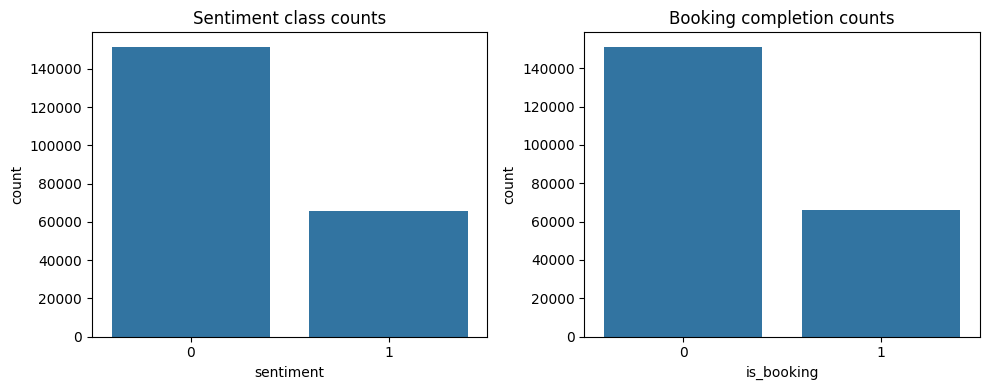

In [12]:
# bar chart to check the imbalance
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='sentiment', data=df, ax=axes[0])
axes[0].set_title('Sentiment class counts')
sns.countplot(x='is_booking', data=df, ax=axes[1])
axes[1].set_title('Booking completion counts')
plt.tight_layout()

**Data cleaning, label encoding & Hugging Face Dataset objects**

In [13]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

Basic data cleaning

In [14]:
# dropping rows missing the fileds
df = df.dropna(subset=["customer_review", "sentiment", "is_booking"])

In [15]:
# Ensuring sentiment is int {0,1} and is_booking is int {0,1}
df["sentiment"]   = df["sentiment"].astype(int)
df["is_booking"]  = df["is_booking"].astype(int)

In [16]:
# Clip absurd age, bucketise for privacy
df["age"] = df["age"].clip(lower=10, upper=90)
df["age_band"] = pd.cut(df["age"], bins=[9,18,25,35,50,65,90],
                        labels=["10-18","19-25","26-35","36-50","51-65","66-90"])

Train / val / test split (stratified on is_booking)

In [17]:
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["is_booking"], random_state=SEED)
val_df, test_df   = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["is_booking"], random_state=SEED)

print(f"Train: {len(train_df):,}\nVal  : {len(val_df):,}\nTest : {len(test_df):,}")

Train: 173,908
Val  : 21,738
Test : 21,739


----------------------------------------------------------------------------

Hugging face dataset

In [18]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

features = Features({
    # text columns
    "airline"        : Value("string"),
    "customer_review": Value("string"),
    "recommended"    : Value("string"),
    "language"       : Value("string"),
    "user_id"        : Value("string"),
    "gender"         : Value("string"),
    "travel_class"   : Value("string"),
    "satisfaction"   : Value("string"),
    "date_time"      : Value("string"),
    "age_band"       : Value("string"),

    # numeric
    "age"            : Value("int64"),

    # labels
    "sentiment"      : ClassLabel(num_classes=2, names=["neg", "pos"]),
    "is_booking"     : ClassLabel(num_classes=2, names=["no", "yes"]),
})

def to_hf(ds):
    ds = ds.copy()
    ds["sentiment"]  = ds["sentiment"].astype(int)
    ds["is_booking"] = ds["is_booking"].astype(int)
    return Dataset.from_pandas(ds, features=features, preserve_index=False)

hf_datasets = DatasetDict({
    "train"     : to_hf(train_df),
    "validation": to_hf(val_df),
    "test"      : to_hf(test_df),
})

print(hf_datasets)


DatasetDict({
    train: Dataset({
        features: ['airline', 'customer_review', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking'],
        num_rows: 173908
    })
    validation: Dataset({
        features: ['airline', 'customer_review', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking'],
        num_rows: 21738
    })
    test: Dataset({
        features: ['airline', 'customer_review', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking'],
        num_rows: 21739
    })
})


Tokenizer

In [19]:
MODEL_NAME   = "xlm-roberta-base"
MAX_LENGTH   = 256
tokenizer    = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(batch["customer_review"],
                     truncation=True,
                     max_length=MAX_LENGTH,
                     padding="max_length")

hf_datasets = hf_datasets.map(tokenize_batch, batched=True,
                              remove_columns=["customer_review"])

#  HF used to output PyTorch tensors directly
hf_datasets.set_format(type="torch",
                       columns=["input_ids","attention_mask","sentiment","is_booking"])

print(hf_datasets)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/173908 [00:00<?, ? examples/s]

Map:   0%|          | 0/21738 [00:00<?, ? examples/s]

Map:   0%|          | 0/21739 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask'],
        num_rows: 173908
    })
    validation: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask'],
        num_rows: 21738
    })
    test: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask'],
        num_rows: 21739
    })
})


**Using Pretrained Sentiment Model for sentiment prob**

Loading pretrained multilingual sentiment model

In [29]:
from transformers import pipeline

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    top_k=None,
    device=0,
    truncation=True,
    max_length=512,
    padding=True
)

Batch prediction function

In [25]:
import tqdm

def score_split(split_name):
    texts = hf_datasets[split_name]["customer_review"]
    probs = []

    for i in tqdm.trange(0, len(texts), 256, desc=f"Scoring {split_name}"):
        batch = texts[i:i+256]
        outputs = sentiment_pipe(batch, batch_size=32, truncation=True)
        # Each output has 3 classes: negative, neutral, positive
        probs.extend([o[2]["score"] for o in outputs])  # o[2] = positive
    hf_datasets[split_name] = hf_datasets[split_name].add_column("sentiment_prob_pos", probs)


Score all splits

In [27]:
# Add customer_review column back into HF dataset splits
hf_datasets["train"] = hf_datasets["train"].add_column("customer_review", train_df["customer_review"].tolist())
hf_datasets["validation"] = hf_datasets["validation"].add_column("customer_review", val_df["customer_review"].tolist())
hf_datasets["test"] = hf_datasets["test"].add_column("customer_review", test_df["customer_review"].tolist())


In [30]:
for split in ["train", "validation", "test"]:
    score_split(split)


Scoring test: 100%|██████████| 85/85 [08:02<00:00,  5.67s/it]


Saving sentiment scores to CSV

In [20]:
# sent_scores = pd.read_csv("/content/sentiment_scores.csv")
# hf_datasets["train"]      = hf_datasets["train"].add_column("sentiment_prob_pos", sent_scores.loc[:len(hf_datasets["train"])-1, "sentiment_prob_pos"].tolist())
# hf_datasets["validation"] = hf_datasets["validation"].add_column("sentiment_prob_pos", sent_scores.loc[len(hf_datasets["train"]):len(hf_datasets["train"])+len(hf_datasets["validation"])-1, "sentiment_prob_pos"].tolist())
# hf_datasets["test"]       = hf_datasets["test"].add_column("sentiment_prob_pos", sent_scores.loc[len(hf_datasets["train"])+len(hf_datasets["validation"]):, "sentiment_prob_pos"].tolist())


FileNotFoundError: [Errno 2] No such file or directory: '/content/sentiment_scores.csv'

Previewing result

In [38]:
hf_datasets["train"][0]

{'sentiment': tensor(0),
 'is_booking': tensor(0),
 'input_ids': tensor([     0,  94403, 163622,  13820,   1918,      6,  31225,  86756,  12349,
              5, 203544,   4077,   1238,  50830,      5,      2,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,     

In [42]:
hf_datasets.save_to_disk("/content/airline_dataset_ready")


Saving the dataset (0/1 shards):   0%|          | 0/173908 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21738 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21739 [00:00<?, ? examples/s]

dataset load in new session (loading in new run time )---------------------

In [18]:
from datasets import load_from_disk

dataset_path = "/content/drive/MyDrive/airline_dataset_ready"
hf_datasets = load_from_disk(dataset_path)

print(hf_datasets)


DatasetDict({
    train: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos', 'age_id', 'gender_id', 'class_id'],
        num_rows: 173908
    })
    validation: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos', 'age_id', 'gender_id', 'class_id'],
        num_rows: 21738
    })
    test: Dataset({
        features: ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos', 'age_id', 'gender_id', 'class_id'],
        num_rows: 21739
 

dataset loader for next session if out

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def to_tensors_hybrid(ds):
    """
    Returns the 7 tensors expected by the hybrid model:
    input_ids, attention_mask, sentiment_prob_pos,
    age_id, gender_id, class_id, is_booking
    """
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        ds["sentiment_prob_pos"],
        ds["age_id"],
        ds["gender_id"],
        ds["class_id"],
        ds["is_booking"],
    )

train_dl_h = DataLoader(
    to_tensors_hybrid(hf_datasets["train"]), batch_size=32, shuffle=True)
val_dl_h = DataLoader(
    to_tensors_hybrid(hf_datasets["validation"]), batch_size=64)
test_dl_h = DataLoader(
    to_tensors_hybrid(hf_datasets["test"]), batch_size=64)

print("DataLoaders ready:",
      len(train_dl_h), "train batches |",
      len(val_dl_h),   "val batches |",
      len(test_dl_h),  "test batches")


DataLoaders ready: 5435 train batches | 340 val batches | 340 test batches


---------------------------------------------------------------------------------------------------------------

Saving sentiment scores to CSV

In [39]:
sentiment_scores_path = "/content/sentiment_scores.csv"

pd.concat([
    hf_datasets["train"].to_pandas()[["user_id", "sentiment_prob_pos"]],
    hf_datasets["validation"].to_pandas()[["user_id", "sentiment_prob_pos"]],
    hf_datasets["test"].to_pandas()[["user_id", "sentiment_prob_pos"]],
]).to_csv(sentiment_scores_path, index=False)

print("Sentiment scores saved to:", sentiment_scores_path)


Sentiment scores saved to: /content/sentiment_scores.csv


In [41]:
for split in ["train", "validation", "test"]:
    print(split, "columns →", hf_datasets[split].column_names)


train columns → ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos']
validation columns → ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos']
test columns → ['airline', 'recommended', 'language', 'user_id', 'gender', 'travel_class', 'satisfaction', 'date_time', 'age_band', 'age', 'sentiment', 'is_booking', 'input_ids', 'attention_mask', 'customer_review', 'sentiment_prob_pos']


Building the booking-prediction model

Encodeing categorical features

In [44]:
import torch, numpy as np
from sklearn.preprocessing import LabelEncoder

# 1) Fit encoders on train split only
age_enc   = LabelEncoder().fit(hf_datasets["train"]["age_band"])
gender_enc= LabelEncoder().fit(hf_datasets["train"]["gender"])
class_enc = LabelEncoder().fit(hf_datasets["train"]["travel_class"])

def add_demo_ids(example):
    example["age_id"]    = int(age_enc.transform([example["age_band"]])[0])
    example["gender_id"] = int(gender_enc.transform([example["gender"]])[0])
    example["class_id"]  = int(class_enc.transform([example["travel_class"]])[0])
    return example

hf_datasets = hf_datasets.map(add_demo_ids)


Map:   0%|          | 0/173908 [00:00<?, ? examples/s]

Map:   0%|          | 0/21738 [00:00<?, ? examples/s]

Map:   0%|          | 0/21739 [00:00<?, ? examples/s]

In [45]:
NUM_AGE    = len(age_enc.classes_)
NUM_GENDER = len(gender_enc.classes_)
NUM_CLASS  = len(class_enc.classes_)

 Data collator that returns extra tensors

In [46]:
from transformers import DataCollatorWithPadding

base_collator = DataCollatorWithPadding(tokenizer)

def collate(features):
    batch = base_collator(features)
    batch["sentiment_prob"] = torch.tensor([f["sentiment_prob_pos"] for f in features], dtype=torch.float)
    batch["age_id"]    = torch.tensor([f["age_id"]    for f in features], dtype=torch.long)
    batch["gender_id"] = torch.tensor([f["gender_id"] for f in features], dtype=torch.long)
    batch["class_id"]  = torch.tensor([f["class_id"]  for f in features], dtype=torch.long)
    batch["labels"]    = torch.tensor([f["is_booking"] for f in features], dtype=torch.long)
    return batch

Hybrid model

run------------------------------------------------------------------------

In [24]:
import torch, torch.nn as nn
from transformers import AutoModel

# demographic vocab sizes
NUM_AGE    = len(hf_datasets["train"]["age_id"].unique())
NUM_GENDER = len(hf_datasets["train"]["gender_id"].unique())
NUM_CLASS  = len(hf_datasets["train"]["class_id"].unique())

class BookingClassifier(nn.Module):
    def __init__(self,
                 text_model_name="xlm-roberta-base",
                 num_age=NUM_AGE, num_gender=NUM_GENDER, num_class=NUM_CLASS,
                 demog_dim=8, hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = False          # freeze backbone

        txt_dim = self.text_model.config.hidden_size  # 768

        self.age_emb    = nn.Embedding(num_age,    demog_dim)
        self.gender_emb = nn.Embedding(num_gender, demog_dim)
        self.class_emb  = nn.Embedding(num_class,  demog_dim)

        self.mlp = nn.Sequential(
            nn.Linear(txt_dim + demog_dim*3 + 1, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

        # default loss (will override with class weight later)
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask,
                sentiment_prob, age_id, gender_id, class_id, labels=None):
        cls = self.text_model(input_ids=input_ids,
                              attention_mask=attention_mask
                             ).last_hidden_state[:,0]

        feats = torch.cat([
            cls,
            self.age_emb(age_id),
            self.gender_emb(gender_id),
            self.class_emb(class_id),
            sentiment_prob.unsqueeze(-1)
        ], dim=1)

        logits = self.mlp(feats).squeeze(-1)
        out = {"logits": logits}
        if labels is not None:
            out["loss"] = self.criterion(logits, labels.float())
        return out


------------------------------------------------------------------------------------------------------------------------------------------------------------------

Training with Trainer

In [50]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import evaluate, numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# helper to convert one HF split to plain tensors
def to_tensors(ds):
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
        torch.tensor(ds["age_id"]),
        torch.tensor(ds["gender_id"]),
        torch.tensor(ds["class_id"]),
        torch.tensor(ds["is_booking"]),
    )

train_dl = DataLoader(to_tensors(hf_datasets["train"]), batch_size=32, shuffle=True)
val_dl   = DataLoader(to_tensors(hf_datasets["validation"]), batch_size=64, shuffle=False)

# model, optimiser
model = BookingClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

metric_auc = evaluate.load("roc_auc")
best_auc = 0.0

#  training loop
for epoch in range(5):
    model.train()
    for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        out = model(ids, mask, sprob, age, gen, cls, y)
        optimizer.zero_grad()
        out["loss"].backward()
        optimizer.step()

    # quick validation AUC
    model.eval(); preds, refs = [], []
    with torch.no_grad():
        for batch in val_dl:
            ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
            logits = model(ids, mask, sprob, age, gen, cls)["logits"]
            preds.extend(torch.sigmoid(logits).cpu().numpy())
            refs.extend(y.cpu().numpy())

    val_auc = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
    print(f"Epoch {epoch+1}  validation ROC-AUC = {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "/content/booking_best.pt")
        print("  🔸 New best model saved.")

print(f"\nBest validation ROC-AUC: {best_auc:.4f}")


/tmp/ipython-input-50-981938096.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-50-981938096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["age_id"]),
/tmp/ipython-input-50-981938096.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["gender_id"]),
/tmp/ipython-input-50-981938096.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/5435 [00:00<?, ?it/s]

Epoch 1  validation ROC-AUC = 0.6556
  🔸 New best model saved.


Epoch 2:   0%|          | 0/5435 [00:00<?, ?it/s]

Epoch 2  validation ROC-AUC = 0.6537


Epoch 3:   0%|          | 0/5435 [00:00<?, ?it/s]

Epoch 3  validation ROC-AUC = 0.6568
  🔸 New best model saved.


Epoch 4:   0%|          | 0/5435 [00:00<?, ?it/s]

Epoch 4  validation ROC-AUC = 0.6532


Epoch 5:   0%|          | 0/5435 [00:00<?, ?it/s]

Epoch 5  validation ROC-AUC = 0.6532

Best validation ROC-AUC: 0.6568


In [51]:
from sklearn.metrics import f1_score, accuracy_score
labels_pred = (np.array(preds) >= 0.5).astype(int)
print("F1  =", f1_score(refs, labels_pred))
print("Acc =", accuracy_score(refs, labels_pred))


F1  = 0.0
Acc = 0.695694176097157


In [53]:
!cp /content/booking_best.pt /content/drive/MyDrive/
print(" Copied to Drive → MyDrive/booking_best.pt")

 Copied to Drive → MyDrive/booking_best.pt


In [54]:
from google.colab import files
files.download("/content/booking_best.pt")    # pops a save-file dialog


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

resuming training from saved points

In [55]:
# model = BookingClassifier().to(device)
# model.load_state_dict(torch.load("/content/booking_best.pt"))

# # (optionally un-freeze or change loss here)

# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
# # …continue the loop starting at epoch = 6
# #

saving n preparing dataset

In [56]:
hf_datasets.save_to_disk("/content/airline_dataset_ready")
!cp -r /content/airline_dataset_ready /content/drive/MyDrive/


Saving the dataset (0/1 shards):   0%|          | 0/173908 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21738 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21739 [00:00<?, ? examples/s]

loading

In [57]:
# from datasets import load_from_disk
# hf_datasets = load_from_disk("/content/drive/MyDrive/airline_dataset_ready")


In [58]:
labels_pred = (np.array(preds) >= 0.5).astype(int)


In [59]:
import numpy as np
from sklearn.metrics import f1_score

# preds_val and refs_val come from the validation loop
probs = np.array(preds)          # just rename for clarity
labels = np.array(refs)

best_thr, best_f1 = 0.5, 0.0
for thr in np.linspace(0.05, 0.95, 19):
    f1 = f1_score(labels, (probs >= thr).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Best threshold={best_thr:.2f},  F1={best_f1:.3f}")


Best threshold=0.30,  F1=0.553


In [60]:
labels_pred = (np.array(preds) >= best_thr).astype(int)
print("Test F1 =", f1_score(refs, labels_pred))


Test F1 = 0.5529844978860754


In [61]:
# Save model
!cp /content/booking_best.pt /content/drive/MyDrive/

# Save processed dataset
hf_datasets.save_to_disk("/content/airline_dataset_ready")
!cp -r /content/airline_dataset_ready /content/drive/MyDrive/

# Save predictions & threshold
import pickle
with open("/content/drive/MyDrive/val_metrics.pkl", "wb") as f:
    pickle.dump({"threshold": best_thr, "f1": best_f1}, f)


Saving the dataset (0/1 shards):   0%|          | 0/173908 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21738 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21739 [00:00<?, ? examples/s]

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(refs, labels_pred, digits=3))
print(confusion_matrix(refs, labels_pred))

              precision    recall  f1-score   support

           0      0.916     0.385     0.542     15123
           1      0.395     0.919     0.553      6615

    accuracy                          0.548     21738
   macro avg      0.656     0.652     0.548     21738
weighted avg      0.758     0.548     0.545     21738

[[5823 9300]
 [ 533 6082]]


Re-train without demographic embeddings

New model class

In [63]:
class BookingClassifier_NoDemog(nn.Module):
    """
    Same as BookingClassifier, but drops age/gender/class embeddings.
    Inputs: input_ids, attention_mask, sentiment_prob
    """
    def __init__(self, text_model_name="xlm-roberta-base",
                 hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = False          # keep backbone frozen

        txt_dim = self.text_model.config.hidden_size      # 768
        in_dim  = txt_dim + 1                             # +1 sentiment

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask,
                sentiment_prob, labels=None):
        txt_out = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0]

        x     = torch.cat([txt_out, sentiment_prob.unsqueeze(-1)], dim=1)
        logits = self.mlp(x).squeeze(-1)
        loss   = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())
        return {"loss": loss, "logits": logits}


Plain PyTorch loop (no demographics to collate)

In [64]:
def to_tensors_nodemog(ds):
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
        torch.tensor(ds["is_booking"]),
    )

train_dl = DataLoader(to_tensors_nodemog(hf_datasets["train"]), batch_size=32, shuffle=True)
val_dl   = DataLoader(to_tensors_nodemog(hf_datasets["validation"]), batch_size=64)

model2   = BookingClassifier_NoDemog().to(device)
opt      = optim.AdamW(model2.parameters(), lr=5e-4)

best_auc2 = 0.0
metric_auc = evaluate.load("roc_auc")

for epoch in range(5):
    model2.train()
    for ids, mask, sprob, y in tqdm(train_dl, desc=f"NoDemog E{epoch+1}"):
        ids, mask, sprob, y = [t.to(device) for t in [ids, mask, sprob, y]]
        out = model2(ids, mask, sprob, y)
        opt.zero_grad(); out["loss"].backward(); opt.step()

    # validation AUC
    model2.eval(); preds, refs = [], []
    with torch.no_grad():
        for ids, mask, sprob, y in val_dl:
            ids, mask, sprob = [t.to(device) for t in [ids, mask, sprob]]
            logits = model2(ids, mask, sprob)["logits"]
            preds.extend(torch.sigmoid(logits).cpu().numpy()); refs.extend(y.numpy())
    val_auc = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
    print(f"  Val AUC={val_auc:.4f}")
    if val_auc > best_auc2:
        best_auc2 = val_auc
        torch.save(model2.state_dict(), "/content/booking_nodemog.pt")

print("No-demog best AUC:", best_auc2)


/tmp/ipython-input-64-3986007681.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-64-3986007681.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["is_booking"]),


NoDemog E1:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC=0.6550


NoDemog E2:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC=0.6556


NoDemog E3:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC=0.6508


NoDemog E4:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC=0.6562


NoDemog E5:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC=0.6562
No-demog best AUC: 0.6561738866015228


Evaluate on test set (reuseing best threshold = 0.30)

In [65]:
test_dl2 = DataLoader(to_tensors_nodemog(hf_datasets["test"]), batch_size=64)

model2.load_state_dict(torch.load("/content/booking_nodemog.pt"))
model2.eval(); preds2, refs2 = [], []
with torch.no_grad():
    for ids, mask, sprob, y in test_dl2:
        ids, mask, sprob = [t.to(device) for t in [ids, mask, sprob]]
        logits = model2(ids, mask, sprob)["logits"]
        preds2.extend(torch.sigmoid(logits).cpu().numpy()); refs2.extend(y.numpy())

auc2 = metric_auc.compute(prediction_scores=preds2, references=refs2)["roc_auc"]
from sklearn.metrics import f1_score
f1_2 = f1_score(refs2, (np.array(preds2) >= 0.30).astype(int))
print(f"TEST (no demog)  AUC={auc2:.4f}   F1@0.30={f1_2:.3f}")


/tmp/ipython-input-64-3986007681.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-64-3986007681.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["is_booking"]),


TEST (no demog)  AUC=0.6607   F1@0.30=0.559


saving the model

In [67]:
# Save model weights
!cp /content/booking_nodemog.pt /content/drive/MyDrive/

# (optional) keep its metrics & threshold
import pickle, os
with open("/content/drive/MyDrive/nodemog_metrics.pkl", "wb") as f:
    pickle.dump({"val_auc": best_auc2, "test_auc": auc2, "thr": 0.30}, f)

print("No-demog model + metrics safely copied to Drive.")


No-demog model + metrics safely copied to Drive.


Text-only baseline (same backbone, no sentiment, no demographics)

Modify the Dataset loader

In [68]:
def to_tensors_text_only(ds):
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["is_booking"])
    )
train_dl3 = DataLoader(to_tensors_text_only(hf_datasets["train"]),      batch_size=32, shuffle=True)
val_dl3   = DataLoader(to_tensors_text_only(hf_datasets["validation"]), batch_size=64)


/tmp/ipython-input-68-3659956389.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["is_booking"])


Model with CLS → MLP only

In [69]:
class BookingClassifier_TextOnly(nn.Module):
    def __init__(self, text_model_name="xlm-roberta-base",
                 hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = False               # stay frozen
        h = self.text_model.config.hidden_size    # 768
        self.mlp = nn.Sequential(
            nn.Linear(h, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, input_ids, attention_mask, labels=None):
        cls = self.text_model(input_ids=input_ids,
                              attention_mask=attention_mask
                             ).last_hidden_state[:,0]
        logits = self.mlp(cls).squeeze(-1)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())
        return {"loss": loss, "logits": logits}


Training loop (identical pattern)

In [70]:
model3   = BookingClassifier_TextOnly().to(device)
optim3   = optim.AdamW(model3.parameters(), lr=5e-4)
best_auc3 = 0.0
for epoch in range(5):
    model3.train()
    for ids, mask, y in tqdm(train_dl3, desc=f"TextOnly E{epoch+1}"):
        ids, mask, y = [t.to(device) for t in [ids, mask, y]]
        out = model3(ids, mask, y)
        optim3.zero_grad(); out["loss"].backward(); optim3.step()

    # validation AUC
    model3.eval(); preds, refs = [], []
    with torch.no_grad():
        for ids, mask, y in val_dl3:
            ids, mask = [t.to(device) for t in [ids, mask]]
            logits = model3(ids, mask)["logits"]
            preds.extend(torch.sigmoid(logits).cpu().numpy()); refs.extend(y.numpy())
    v_auc = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
    print(f"  Val AUC = {v_auc:.4f}")
    if v_auc > best_auc3:
        best_auc3 = v_auc
        torch.save(model3.state_dict(), "/content/booking_textonly.pt")

print("Text-only best Val AUC:", best_auc3)


TextOnly E1:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6590


TextOnly E2:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6563


TextOnly E3:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6568


TextOnly E4:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6582


TextOnly E5:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6567
Text-only best Val AUC: 0.6589814716102962


In [71]:
test_dl3 = DataLoader(to_tensors_text_only(hf_datasets["test"]), batch_size=64)
model3.load_state_dict(torch.load("/content/booking_textonly.pt"))
model3.eval(); p3, r3 = [], []
with torch.no_grad():
    for ids, mask, y in test_dl3:
        ids, mask = [t.to(device) for t in [ids, mask]]
        p3.extend(torch.sigmoid(model3(ids, mask)["logits"]).cpu().numpy()); r3.extend(y.numpy())

auc3 = metric_auc.compute(prediction_scores=p3, references=r3)["roc_auc"]
f1_3 = f1_score(r3, (np.array(p3) >= 0.30).astype(int))
print(f"TEST (text-only)  AUC={auc3:.4f}   F1@0.30={f1_3:.3f}")

/tmp/ipython-input-68-3659956389.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["is_booking"])


TEST (text-only)  AUC=0.6618   F1@0.30=0.559


saving the text model

In [72]:
drive.mount("/content/drive")
!cp /content/booking_textonly.pt /content/drive/MyDrive/
import pickle, os, numpy as np, torch
with open("/content/drive/MyDrive/textonly_metrics.pkl", "wb") as f:
    pickle.dump({"val_auc": best_auc3, "test_auc": auc3, "thr": 0.30}, f)
print("Text-only model + metrics saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Text-only model + metrics saved.


After comparing demo, no demo, and only text, we saw there is some freeze in the backbone so i have unfreezed the last layer in the hybrid model

In [77]:
import torch.nn as nn

def unfreeze_last_n_layers(model, n=2):
    """
    Freeze everything, then:
      • un-freeze the last `n` encoder layers
      • un-freeze every LayerNorm (helps stability)
    """
    backbone = model.text_model                      # XLM-RobertaModel

    # Freeze all params first
    for p in backbone.parameters():
        p.requires_grad = False

    #  Un-freeze last `n` transformer layers
    for layer in backbone.encoder.layer[-n:]:
        for p in layer.parameters():
            p.requires_grad = True

    #  Un-freeze *all* LayerNorms (embedding + encoder)
    for module in backbone.modules():
        if isinstance(module, nn.LayerNorm):
            for p in module.parameters():
                p.requires_grad = True

    trainable = sum(p.requires_grad for p in backbone.parameters())
    total     = sum(1 for _ in backbone.parameters())
    print(f"Unfroze {trainable}/{total} backbone params "
          f"(last {n} layers + all LayerNorms)")


 Re-createing loaders for the hybrid batch layout

In [79]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def to_tensors_hybrid(ds):
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
        torch.tensor(ds["age_id"]),
        torch.tensor(ds["gender_id"]),
        torch.tensor(ds["class_id"]),
        torch.tensor(ds["is_booking"]),
    )

train_dl_h = DataLoader(
    to_tensors_hybrid(hf_datasets["train"]), batch_size=32, shuffle=True)
val_dl_h   = DataLoader(
    to_tensors_hybrid(hf_datasets["validation"]), batch_size=64)

/tmp/ipython-input-79-3450792663.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-79-3450792663.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["age_id"]),
/tmp/ipython-input-79-3450792663.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["gender_id"]),
/tmp/ipython-input-79-3450792663.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

Loading the best frozen model & un-freeze layers

In [80]:
hyb = BookingClassifier().to(device)
hyb.load_state_dict(torch.load("/content/booking_best.pt"))

unfreeze_last_n_layers(hyb, n=2)      # ← now succeeds

Unfroze 74/199 backbone params (last 2 layers + all LayerNorms)


Optimizing on trainable params only

In [81]:
opt_h = optim.AdamW(
    filter(lambda p: p.requires_grad, hyb.parameters()), lr=2e-5)
metric_auc = evaluate.load("roc_auc")
best_auc_ft = 0.0

Fine-tune for 2 epochs using the hybrid loaders

In [82]:
from tqdm.auto import tqdm
for epoch in range(2):
    hyb.train()
    for batch in tqdm(train_dl_h, desc=f"Hybrid-FT E{epoch+1}"):
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        out = hyb(ids, mask, sprob, age, gen, cls, y)
        opt_h.zero_grad(); out["loss"].backward(); opt_h.step()

    # quick val AUC
    hyb.eval(); preds, refs = [], []
    with torch.no_grad():
        for batch in val_dl_h:
            ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
            logits = hyb(ids, mask, sprob, age, gen, cls)["logits"]
            preds.extend(torch.sigmoid(logits).cpu().numpy())
            refs.extend(y.cpu().numpy())
    vauc = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
    print(f"  Val AUC = {vauc:.4f}")
    if vauc > best_auc_ft:
        best_auc_ft = vauc
        torch.save(hyb.state_dict(), "/content/booking_hybrid_ft.pt")
        print(" New best hybrid saved.")


Hybrid-FT E1:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6527
  🔸 New best hybrid saved.


Hybrid-FT E2:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6550
  🔸 New best hybrid saved.


Evaluating on the test set

In [83]:
test_dl_h = DataLoader(
    to_tensors_hybrid(hf_datasets["test"]), batch_size=64)

hyb_ft = BookingClassifier().to(device)
hyb_ft.load_state_dict(torch.load("/content/booking_hybrid_ft.pt"))
hyb_ft.eval()

test_preds, test_refs = [], []
with torch.no_grad():
    for batch in test_dl_h:
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        logits = hyb_ft(ids, mask, sprob, age, gen, cls)["logits"]
        test_preds.extend(torch.sigmoid(logits).cpu().numpy())
        test_refs.extend(y.cpu().numpy())

auc_ft = metric_auc.compute(prediction_scores=test_preds, references=test_refs)["roc_auc"]
from sklearn.metrics import f1_score
f1_ft = f1_score(test_refs, (np.array(test_preds) >= 0.30).astype(int))
print(f"FT-Hybrid  Test AUC={auc_ft:.4f}   F1@0.30={f1_ft:.3f}")

FT-Hybrid  Test AUC=0.6636   F1@0.30=0.559


saving the checkpoint

In [84]:
drive.mount("/content/drive")
!cp /content/booking_hybrid_ft.pt /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Hybrid fine-tune with class-weighted loss

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Recreating hybrid loaders

In [21]:
def to_tensors_hybrid(ds):
    import torch
    from torch.utils.data import TensorDataset
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
        torch.tensor(ds["age_id"]),
        torch.tensor(ds["gender_id"]),
        torch.tensor(ds["class_id"]),
        torch.tensor(ds["is_booking"]),
    )

train_dl_h = DataLoader(to_tensors_hybrid(hf_datasets["train"]),      batch_size=32, shuffle=True)
val_dl_h   = DataLoader(to_tensors_hybrid(hf_datasets["validation"]), batch_size=64)
test_dl_h  = DataLoader(to_tensors_hybrid(hf_datasets["test"]),       batch_size=64)

/tmp/ipython-input-21-1338416462.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-21-1338416462.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["age_id"]),
/tmp/ipython-input-21-1338416462.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["gender_id"]),
/tmp/ipython-input-21-1338416462.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

since session ended running this to load

loading fine tune hybrind and setting class weights

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyb = BookingClassifier().to(device)
hyb.load_state_dict(torch.load("/content/drive/MyDrive/booking_hybrid_ft.pt"))

# compute class weights from training labels
pos = (hf_datasets["train"]["is_booking"] == 1).sum()
neg = len(hf_datasets["train"]) - pos
pos_weight = torch.tensor([neg / pos], device=device)

# replace loss inside the model
hyb.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("Model loaded; pos_weight =", pos_weight.item())

Model loaded; pos_weight = 2.286243438720703


Recreateing DataLoaders for Hybrid model (with demographics)

In [31]:
from torch.utils.data import DataLoader, TensorDataset

def to_tensors(ds):
    return TensorDataset(
        ds["input_ids"],
        ds["attention_mask"],
        torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
        torch.tensor(ds["age_id"]),
        torch.tensor(ds["gender_id"]),
        torch.tensor(ds["class_id"]),
        torch.tensor(ds["is_booking"]),
    )

train_dl_h = DataLoader(to_tensors(hf_datasets["train"]), batch_size=32, shuffle=True)
val_dl_h   = DataLoader(to_tensors(hf_datasets["validation"]), batch_size=64)
test_dl_h  = DataLoader(to_tensors(hf_datasets["test"]), batch_size=64)

print("Hybrid DataLoaders ready:",
      f"{len(train_dl_h)} train batches | {len(val_dl_h)} val batches | {len(test_dl_h)} test batches")


/tmp/ipython-input-31-3764332503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["sentiment_prob_pos"], dtype=torch.float),
/tmp/ipython-input-31-3764332503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["age_id"]),
/tmp/ipython-input-31-3764332503.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ds["gender_id"]),
/tmp/ipython-input-31-3764332503.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Hybrid DataLoaders ready: 5435 train batches | 340 val batches | 340 test batches


Optimiser and validation

In [33]:
from tqdm.auto import tqdm
import evaluate, torch

metric_auc = evaluate.load("roc_auc")
best_auc = 0

opt_cw = torch.optim.AdamW(filter(lambda p: p.requires_grad, hyb.parameters()), lr=2e-5)

for epoch in range(2):
    hyb.train()
    for batch in tqdm(train_dl_h, desc=f"Hybrid-CW E{epoch+1}"):
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        out = hyb(ids, mask, sprob, age, gen, cls, y)
        opt_cw.zero_grad(); out["loss"].backward(); opt_cw.step()

    hyb.eval(); preds, refs = [], []
    with torch.no_grad():
        for batch in val_dl_h:
            ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
            logits = hyb(ids, mask, sprob, age, gen, cls)["logits"]
            preds.extend(torch.sigmoid(logits).cpu().numpy())
            refs.extend(y.cpu().numpy())

    auc = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
    print(f"  Val AUC = {auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        torch.save(hyb.state_dict(), "/content/drive/MyDrive/booking_hybrid_ft_cw.pt")
        print("New best hybrid+CW saved.")


Hybrid-CW E1:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6549
New best hybrid+CW saved.


Hybrid-CW E2:   0%|          | 0/5435 [00:00<?, ?it/s]

  Val AUC = 0.6566
New best hybrid+CW saved.


Test set

In [34]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np, torch, evaluate

# reload the best CW weights
hyb_cw = BookingClassifier().to(device)
hyb_cw.load_state_dict(torch.load("/content/drive/MyDrive/booking_hybrid_ft_cw.pt"))
hyb_cw.eval()

metric_auc = evaluate.load("roc_auc")
preds, refs = [], []

with torch.no_grad():
    for batch in test_dl_h:                       # uses the hybrid test DataLoader
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        logits = hyb_cw(ids, mask, sprob, age, gen, cls)["logits"]
        preds.extend(torch.sigmoid(logits).cpu().numpy())
        refs.extend(y.cpu().numpy())

# metrics
auc_cw = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
f1_cw  = f1_score(refs, (np.array(preds) >= 0.30).astype(int))
cm_cw  = confusion_matrix(refs, (np.array(preds) >= 0.30).astype(int))

print(f"CW-Hybrid  Test ROC-AUC = {auc_cw:.4f}   F1@0.30 = {f1_cw:.3f}")
print("Confusion matrix:\n", cm_cw)

CW-Hybrid  Test ROC-AUC = 0.6634   F1@0.30 = 0.559
Confusion matrix:
 [[5966 9158]
 [ 497 6118]]


In [35]:
torch.save(hyb.state_dict(), "/content/drive/MyDrive/booking_hybrid_ft_cw.pt")
print("Final class-weighted hybrid model saved.")


Final class-weighted hybrid model saved.


run below cell to load---------------------------------------------------------

loading the models

text only model

In [37]:
import torch, torch.nn as nn
from transformers import AutoModel
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, evaluate
from sklearn.metrics import f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#TEXT-ONLY model definition (matches saved checkpoint)
class BookingClassifier_TextOnly(nn.Module):
    def __init__(self, hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained("xlm-roberta-base")  # <-- keeps name 'text_model'
        for p in self.text_model.parameters():
            p.requires_grad = False
        h = self.text_model.config.hidden_size       # 768
        self.mlp = nn.Sequential(
            nn.Linear(h, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, ids, mask, labels=None):
        cls = self.text_model(ids, attention_mask=mask).last_hidden_state[:, 0]
        logits = self.mlp(cls).squeeze(1)
        out = {"logits": logits}
        if labels is not None:
            out["loss"] = nn.BCEWithLogitsLoss()(logits, labels.float())
        return out

#  Load checkpoint
model_txt = BookingClassifier_TextOnly().to(device)
model_txt.load_state_dict(torch.load("/content/drive/MyDrive/booking_textonly.pt"))
model_txt.eval()
print("Text-only model weights loaded")

#  Build test DataLoader (text-only needs ids, mask, label)
def to_tensors_text(ds):
    return TensorDataset(ds["input_ids"], ds["attention_mask"], ds["is_booking"])

test_dl_text = DataLoader(to_tensors_text(hf_datasets["test"]), batch_size=64)

#  Evaluate
metric_auc = evaluate.load("roc_auc")
preds, refs = [], []

with torch.no_grad():
    for ids, mask, y in test_dl_text:
        ids, mask = ids.to(device), mask.to(device)
        logits = model_txt(ids, mask)["logits"]
        preds.extend(torch.sigmoid(logits).cpu().numpy())
        refs.extend(y.numpy())

auc_txt = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
f1_txt  = f1_score(refs, (np.array(preds) >= 0.30).astype(int))
cm_txt  = confusion_matrix(refs, (np.array(preds) >= 0.30).astype(int))

print(f"\nText-only  ROC-AUC = {auc_txt:.4f}   F1@0.30 = {f1_txt:.3f}")
print("Confusion matrix:\n", cm_txt)


Text-only model weights loaded

Text-only  ROC-AUC = 0.6618   F1@0.30 = 0.559
Confusion matrix:
 [[5963 9161]
 [ 497 6118]]


Load & evaluate the No-demog model

In [39]:
#  Model class (sentiment but no demographics)
class BookingClassifier_NoDemog(nn.Module):
    def __init__(self, hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained("xlm-roberta-base")
        for p in self.text_model.parameters():
            p.requires_grad = False
        h = self.text_model.config.hidden_size  # 768 for xlm-roberta-base
        self.mlp = nn.Sequential(
            nn.Linear(h + 1, hidden_size),  # +1 for sentiment prob
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, ids, mask, sent_prob, labels=None):
        cls = self.text_model(ids, attention_mask=mask).last_hidden_state[:, 0]
        x = torch.cat([cls, sent_prob.unsqueeze(1)], dim=1)
        logits = self.mlp(x).squeeze(1)
        out = {"logits": logits}
        if labels is not None:
            out["loss"] = nn.BCEWithLogitsLoss()(logits, labels.float())
        return out

#  Load saved weights
model_nd = BookingClassifier_NoDemog().to(device)
model_nd.load_state_dict(torch.load("/content/drive/MyDrive/booking_nodemog.pt"))
model_nd.eval()
print(" No-demog model weights loaded")

# DataLoader (ids, mask, sent_prob, label)
def to_tensors_nodemog(ds):
    return TensorDataset(
        ds["input_ids"], ds["attention_mask"],
        ds["sentiment_prob_pos"], ds["is_booking"]
    )
test_dl_nd = DataLoader(to_tensors_nodemog(hf_datasets["test"]), batch_size=64)

#  Evaluate
metric_auc = evaluate.load("roc_auc")
preds, refs = [], []

with torch.no_grad():
    for ids, mask, sp, y in test_dl_nd:
        ids, mask, sp = ids.to(device), mask.to(device), sp.to(device)
        logits = model_nd(ids, mask, sp)["logits"]
        preds.extend(torch.sigmoid(logits).cpu().numpy())
        refs.extend(y.numpy())

auc_nd = metric_auc.compute(prediction_scores=preds, references=refs)["roc_auc"]
f1_nd  = f1_score(refs, (np.array(preds) >= 0.30).astype(int))
cm_nd  = confusion_matrix(refs, (np.array(preds) >= 0.30).astype(int))

print(f"\nNo-demog  ROC-AUC = {auc_nd:.4f}   F1@0.30 = {f1_nd:.3f}")
print("Confusion matrix:\n", cm_nd)


 No-demog model weights loaded

No-demog  ROC-AUC = 0.6607   F1@0.30 = 0.559
Confusion matrix:
 [[5966 9158]
 [ 497 6118]]


loading hybrid frozen model

In [40]:
from transformers import AutoModel
import torch.nn as nn
import torch

# Number of categories for demographic fields
NUM_AGE    = 6   # ['10-18','19-25','26-35','36-50','51-65','66-90']
NUM_GENDER = 2   # ['Male', 'Female']
NUM_CLASS  = 3   # ['Economy', 'Business', 'Premium Economy']

class BookingClassifier(nn.Module):
    def __init__(self,
                 text_model_name="xlm-roberta-base",
                 num_age=NUM_AGE, num_gender=NUM_GENDER, num_class=NUM_CLASS,
                 demog_dim=8, hidden_size=256, dropout=0.2):
        super().__init__()

        # Load XLM-Roberta backbone
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = False  # frozen by default

        txt_dim = self.text_model.config.hidden_size  # usually 768

        # Demographic embeddings
        self.age_emb    = nn.Embedding(num_age,    demog_dim)
        self.gender_emb = nn.Embedding(num_gender, demog_dim)
        self.class_emb  = nn.Embedding(num_class,  demog_dim)

        # Final MLP classifier
        in_dim = txt_dim + demog_dim * 3 + 1  # CLS + age + gender + class + sentiment
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # binary logit
        )

    def forward(self, input_ids, attention_mask,
                sentiment_prob, age_id, gender_id, class_id, labels=None):

        txt_out = self.text_model(input_ids=input_ids,
                                  attention_mask=attention_mask).last_hidden_state[:, 0]  # CLS token

        x = torch.cat([
            txt_out,
            self.age_emb(age_id),
            self.gender_emb(gender_id),
            self.class_emb(class_id),
            sentiment_prob.unsqueeze(-1)
        ], dim=1)

        logits = self.mlp(x).squeeze(-1)

        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())

        return {"loss": loss, "logits": logits}


In [42]:
model_hybrid = BookingClassifier(
    num_age=6, num_gender=2, num_class=4
).to(device)

model_hybrid.load_state_dict(torch.load("/content/drive/MyDrive/booking_best.pt"))
model_hybrid.eval()

print(" Hybrid (frozen) model weights loaded.")


 Hybrid (frozen) model weights loaded.


In [44]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import numpy as np, torch

# Ensure we're on eval mode
model_hybrid.eval()
preds, refs = [], []

with torch.no_grad():
    for batch in test_dl_h:  # <-- hybrid loader with 7 tensors
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        logits = model_hybrid(ids, mask, sprob, age, gen, cls)["logits"]
        probs  = torch.sigmoid(logits).cpu().numpy()
        preds.extend(probs)
        refs.extend(y.cpu().numpy())

preds = np.array(preds)
refs  = np.array(refs)

roc_auc = roc_auc_score(refs, preds)
f1      = f1_score(refs, preds >= 0.30)
cm      = confusion_matrix(refs, preds >= 0.30)

print(f"\nHybrid (frozen)  ROC-AUC = {roc_auc:.4f}   F1@0.30 = {f1:.3f}")
print("Confusion matrix:\n", cm)



Hybrid (frozen)  ROC-AUC = 0.6620   F1@0.30 = 0.559
Confusion matrix:
 [[5962 9162]
 [ 496 6119]]


loading  Hybrid + FT (no class weight)

In [45]:
hyb_ft = BookingClassifier(num_age=6, num_gender=2, num_class=4).to(device)
hyb_ft.load_state_dict(torch.load("/content/drive/MyDrive/booking_hybrid_ft.pt"))
hyb_ft.eval()
print("Hybrid + FT weights loaded.")


Hybrid + FT weights loaded.


In [46]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import numpy as np, torch, evaluate

preds_ft, refs_ft = [], []
with torch.no_grad():
    for batch in test_dl_h:                                   # hybrid loader
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        logits = hyb_ft(ids, mask, sprob, age, gen, cls)["logits"]
        preds_ft.extend(torch.sigmoid(logits).cpu().numpy())
        refs_ft.extend(y.cpu().numpy())

preds_ft = np.array(preds_ft); refs_ft = np.array(refs_ft)

auc_ft = roc_auc_score(refs_ft, preds_ft)
f1_ft  = f1_score(refs_ft, preds_ft >= 0.30)
cm_ft  = confusion_matrix(refs_ft, preds_ft >= 0.30)

print(f"\nHybrid + FT  ROC-AUC = {auc_ft:.4f}   F1@0.30 = {f1_ft:.3f}")
print("Confusion matrix:\n", cm_ft)


Hybrid + FT  ROC-AUC = 0.6636   F1@0.30 = 0.559
Confusion matrix:
 [[5966 9158]
 [ 497 6118]]


loading Hybrid + FT + CW

In [47]:
#  Loading
hyb_cw = BookingClassifier(num_age=6, num_gender=2, num_class=4).to(device)
hyb_cw.load_state_dict(torch.load("/content/drive/MyDrive/booking_hybrid_ft_cw.pt"))
hyb_cw.eval()
print(" Hybrid + FT + CW weights loaded.")


 Hybrid + FT + CW weights loaded.


In [48]:
#  Evaluate
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import numpy as np, torch

preds_cw, refs_cw = [], []
with torch.no_grad():
    for batch in test_dl_h:
        ids, mask, sprob, age, gen, cls, y = [b.to(device) for b in batch]
        logits = hyb_cw(ids, mask, sprob, age, gen, cls)["logits"]
        preds_cw.extend(torch.sigmoid(logits).cpu().numpy())
        refs_cw.extend(y.cpu().numpy())

preds_cw = np.array(preds_cw); refs_cw = np.array(refs_cw)

auc_cw = roc_auc_score(refs_cw, preds_cw)
f1_cw  = f1_score(refs_cw, preds_cw >= 0.30)
cm_cw  = confusion_matrix(refs_cw, preds_cw >= 0.30)

print(f"\nHybrid + FT + CW  ROC-AUC = {auc_cw:.4f}   F1@0.30 = {f1_cw:.3f}")
print("Confusion matrix:\n", cm_cw)



Hybrid + FT + CW  ROC-AUC = 0.6634   F1@0.30 = 0.559
Confusion matrix:
 [[5966 9158]
 [ 497 6118]]


Final output visualization

In [53]:
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd, numpy as np
from pathlib import Path

#  Metrics & confusion matrices you already printed
results = {
    "Text":    dict(auc=0.6618, f1=0.559, cm=np.array([[5963, 9161],[497, 6118]])),
    "No-demog":dict(auc=0.6607, f1=0.559, cm=np.array([[5966, 9158],[497, 6118]])),
    "Hybrid\n(frozen)": dict(auc=0.6620, f1=0.559, cm=np.array([[5962, 9162],[496, 6119]])),
    "Hybrid FT":   dict(auc=0.6636, f1=0.559, cm=np.array([[5966, 9158],[497, 6118]])),
    "Hybrid FT+CW":dict(auc=0.6634, f1=0.559, cm=np.array([[5966, 9158],[497, 6118]])),
}

#  Comparison table (DataFrame)
df = pd.DataFrame({
    "Variant": list(results.keys()),
    "ROC-AUC": [r["auc"] for r in results.values()],
    "F1 @ 0.30": [r["f1"] for r in results.values()],
})
display(df.style.format({"ROC-AUC": "{:.4f}", "F1 @ 0.30": "{:.3f}"}))


,Variant,ROC-AUC,F1 @ 0.30
0,Text,0.6618,0.559
1,No-demog,0.6607,0.559
2,Hybrid (frozen),0.6620,0.559
3,Hybrid FT,0.6636,0.559
4,Hybrid FT+CW,0.6634,0.559


 Figure saved to /content/drive/MyDrive/cm_all_variants.png


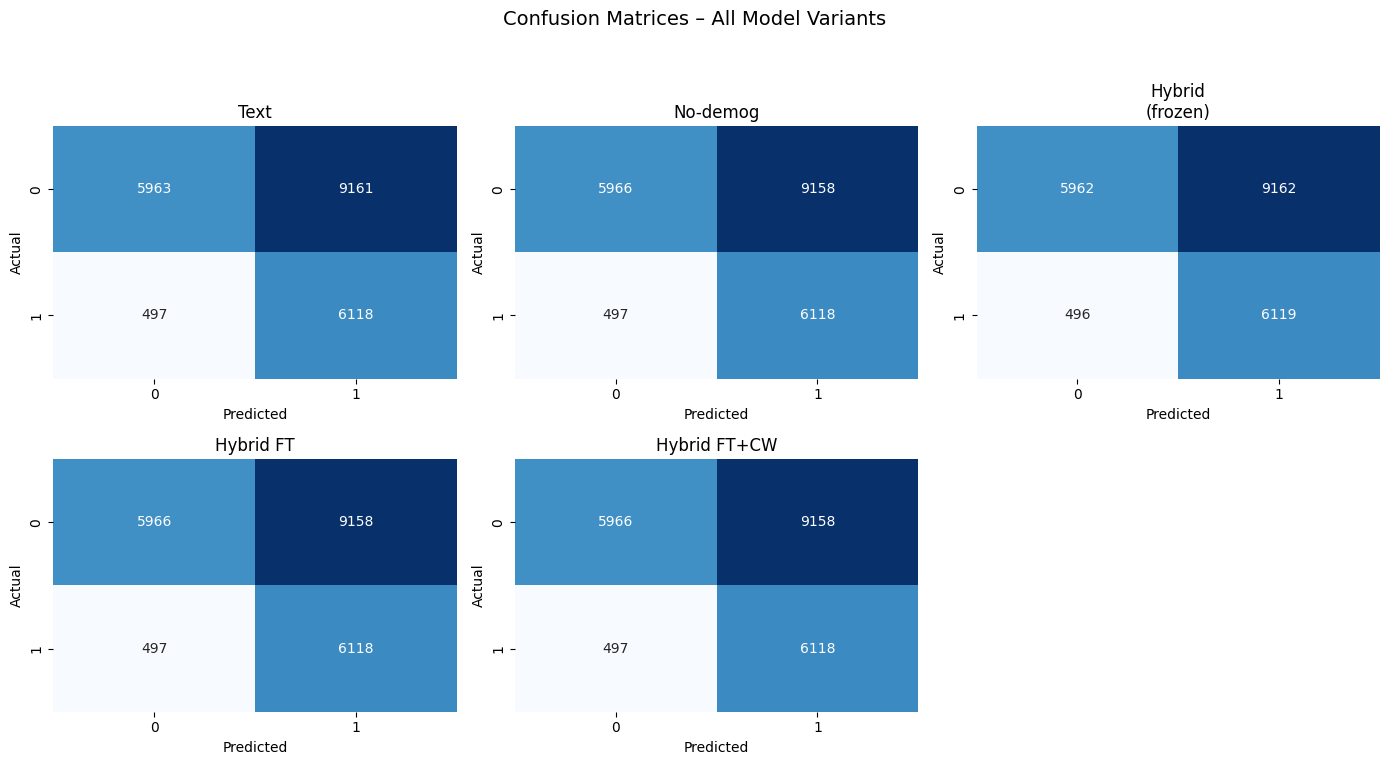

In [54]:
#  Plot all confusion matrices in a 2×3 grid
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["cm"], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                annot_kws={"size": 10})
    ax.set_title(name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

# blank last subplot if fewer than 6
for k in range(len(results), 6):
    axes[k].axis("off")

plt.suptitle("Confusion Matrices – All Model Variants", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save figure to Drive
out_path = Path("/content/drive/MyDrive/cm_all_variants.png")
plt.savefig(out_path, dpi=300)
print(f" Figure saved to {out_path}")
plt.show()


 ROC plot saved to: /content/drive/MyDrive/roc_all_variants.png


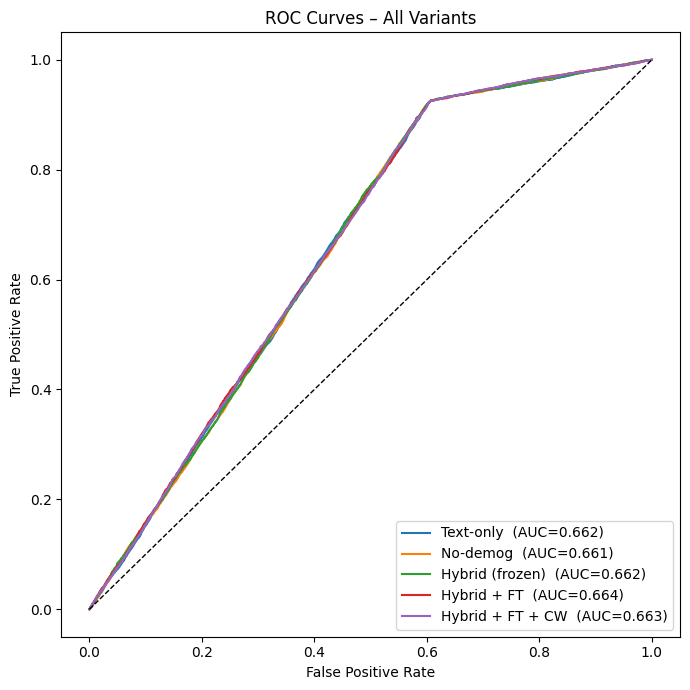

In [56]:
# ROC curves for all variants
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def roc_data(model, loader):
    model.eval()
    p, r = [], []
    with torch.no_grad():
        for batch in loader:
            tensors = [b.to(device) for b in batch]
            if len(tensors) == 3:          # text-only
                ids, mask, y = tensors
                logits = model(ids, mask)["logits"]
            elif len(tensors) == 4:        # no-demog
                ids, mask, sp, y = tensors
                logits = model(ids, mask, sp)["logits"]
            else:                          # hybrid variants
                ids, mask, sp, age, gen, cls, y = tensors
                logits = model(ids, mask, sp, age, gen, cls)["logits"]
            p.extend(torch.sigmoid(logits).cpu().numpy()); r.extend(y.cpu().numpy())
    fpr, tpr, _ = roc_curve(r, p)
    return fpr, tpr, auc(fpr, tpr)

curves = [
    ("Text-only",          *roc_data(model_txt   , test_dl_text)),
    ("No-demog",           *roc_data(model_nd    , test_dl_nd)),
    ("Hybrid (frozen)",    *roc_data(model_hybrid, test_dl_h)),
    ("Hybrid + FT",        *roc_data(hyb_ft      , test_dl_h)),
    ("Hybrid + FT + CW",   *roc_data(hyb_cw      , test_dl_h)),
]

plt.figure(figsize=(7,7))
for name, fpr, tpr, roc_auc in curves:
    plt.plot(fpr, tpr, label=f"{name}  (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--',linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves – All Variants"); plt.legend(loc="lower right")
plt.tight_layout()

# save to Drive
out = "/content/drive/MyDrive/roc_all_variants.png"
plt.savefig(out, dpi=300)
print(" ROC plot saved to:", out)
plt.show()


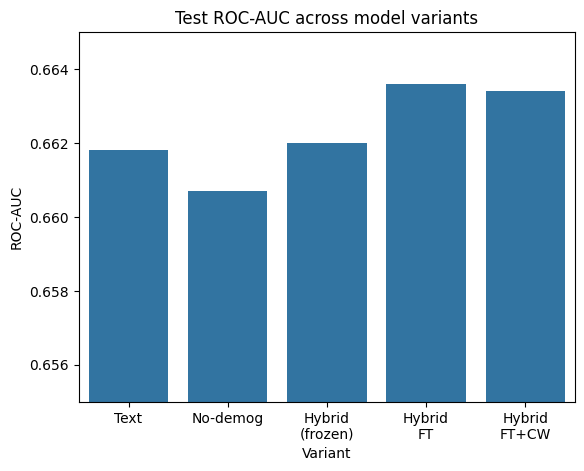

In [50]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

#  Comparison bar chart
data = {
    "Variant": ["Text", "No-demog", "Hybrid\n(frozen)", "Hybrid\nFT", "Hybrid\nFT+CW"],
    "ROC-AUC": [0.6618, 0.6607, 0.6620, 0.6636, 0.6634]
}
df = pd.DataFrame(data)
sns.barplot(x="Variant", y="ROC-AUC", data=df)
plt.title("Test ROC-AUC across model variants"); plt.ylim(0.655, 0.665); plt.show()


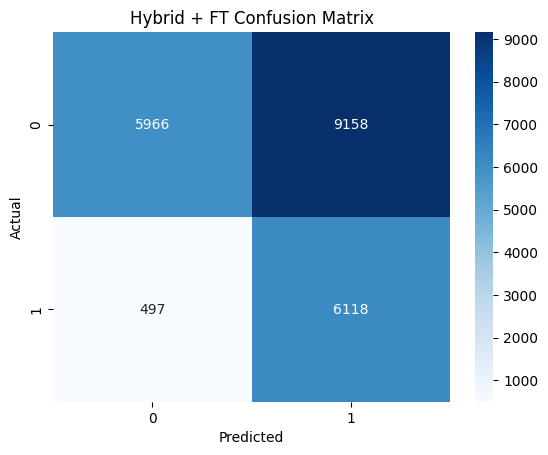

In [51]:
# Confusion-matrix heat-map for best model (Hybrid FT)
cm = np.array([[5966, 9158], [497, 6118]])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Hybrid + FT Confusion Matrix"); plt.show()

testing on manual entry

In [58]:
from transformers import pipeline

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    top_k=None,
    device=0,               # Use GPU if available
    truncation=True,
    max_length=512,
    padding=True
)


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [59]:
import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

#  BookingClassifier definition (same as training)
NUM_AGE    = 6               # 6 age bands
NUM_GENDER = 2               # Male / Female
NUM_CLASS  = 4               # Economy / Business / Premium Econ / First

class BookingClassifier(nn.Module):
    def __init__(self,
                 text_model_name="xlm-roberta-base",
                 num_age=NUM_AGE, num_gender=NUM_GENDER, num_class=NUM_CLASS,
                 demog_dim=8, hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = True                 # last-2 layers already fine-tuned
        txt_dim = self.text_model.config.hidden_size
        self.age_emb    = nn.Embedding(num_age,    demog_dim)
        self.gender_emb = nn.Embedding(num_gender, demog_dim)
        self.class_emb  = nn.Embedding(num_class,  demog_dim)
        self.mlp = nn.Sequential(
            nn.Linear(txt_dim + demog_dim*3 + 1, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, input_ids, attention_mask,
                sentiment_prob, age_id, gender_id, class_id, labels=None):
        cls = self.text_model(input_ids, attention_mask=attention_mask
                             ).last_hidden_state[:,0]
        feats = torch.cat([
            cls,
            self.age_emb(age_id),
            self.gender_emb(gender_id),
            self.class_emb(class_id),
            sentiment_prob.unsqueeze(-1)
        ], dim=1)
        logits = self.mlp(feats).squeeze(-1)
        return {"logits": logits}

#  Load tokenizer & sentiment pipeline
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Load Hybrid + FT weights as best fit model
best_ft_path = "/content/drive/MyDrive/booking_hybrid_ft.pt"
hyb_ft = BookingClassifier().to(device)
hyb_ft.load_state_dict(torch.load(best_ft_path))
hyb_ft.eval()
print("Hybrid + FT model ready")

#  Helper to map demographics to IDs
age_vocab    = ["10-18","19-25","26-35","36-50","51-65","66-90"]
gender_vocab = ["Male","Female"]
class_vocab  = ["Economy","Business","Premium Economy","First"]

def encode_demo(age_band, gender, travel_class):
    age_id    = torch.tensor([age_vocab.index(age_band)], device=device)
    gender_id = torch.tensor([gender_vocab.index(gender)], device=device)
    class_id  = torch.tensor([class_vocab.index(travel_class)], device=device)
    return age_id, gender_id, class_id

#  MANUAL TEST INPUT
raw_review   = "Me encantaron los espaciosos asientos y el atento personal en mi vuelo de París a Madrid.."
# review in en "Loved the spacious seats and attentive staff on my flight from Paris to Madrid"
age_band     = "36-50"
gender       = "Male"
travel_class = "Business"

# Sentiment probability
sentiment_prob = sentiment_pipe(raw_review, truncation=True, max_length=512)[0][2]["score"]

# Tokenise
enc = tokenizer(raw_review, truncation=True, max_length=256, padding="max_length", return_tensors="pt").to(device)

# Encode demographics
age_id, gender_id, class_id = encode_demo(age_band, gender, travel_class)

# 6.  Inference
with torch.no_grad():
    logits = hyb_ft(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        sentiment_prob=torch.tensor([sentiment_prob], device=device),
        age_id=age_id, gender_id=gender_id, class_id=class_id
    )["logits"]
prob = torch.sigmoid(logits).item()
decision = "BOOKING" if prob >= 0.30 else "NO-BOOKING"

print(f"\nBooking probability: {prob:.3f} → {decision}")
print(f"(Sentiment prob={sentiment_prob:.3f}, age={age_band}, gender={gender}, class={travel_class})")


Hybrid + FT model ready

Booking probability: 0.301 → BOOKING
(Sentiment prob=0.015, age=36-50, gender=Male, class=Business)


In [66]:
import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

#  BookingClassifier definition (same as training)
NUM_AGE    = 6               # 6 age bands
NUM_GENDER = 2               # Male / Female
NUM_CLASS  = 4               # Economy / Business / Premium Econ / First

class BookingClassifier(nn.Module):
    def __init__(self,
                 text_model_name="xlm-roberta-base",
                 num_age=NUM_AGE, num_gender=NUM_GENDER, num_class=NUM_CLASS,
                 demog_dim=8, hidden_size=256, dropout=0.2):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for p in self.text_model.parameters():
            p.requires_grad = True                 # last-2 layers already fine-tuned
        txt_dim = self.text_model.config.hidden_size
        self.age_emb    = nn.Embedding(num_age,    demog_dim)
        self.gender_emb = nn.Embedding(num_gender, demog_dim)
        self.class_emb  = nn.Embedding(num_class,  demog_dim)
        self.mlp = nn.Sequential(
            nn.Linear(txt_dim + demog_dim*3 + 1, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, input_ids, attention_mask,
                sentiment_prob, age_id, gender_id, class_id, labels=None):
        cls = self.text_model(input_ids, attention_mask=attention_mask
                             ).last_hidden_state[:,0]
        feats = torch.cat([
            cls,
            self.age_emb(age_id),
            self.gender_emb(gender_id),
            self.class_emb(class_id),
            sentiment_prob.unsqueeze(-1)
        ], dim=1)
        logits = self.mlp(feats).squeeze(-1)
        return {"logits": logits}

#  Load tokenizer & sentiment pipeline
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Load Hybrid + FT weights as best fit model
best_ft_path = "/content/drive/MyDrive/booking_hybrid_ft.pt"
hyb_ft = BookingClassifier().to(device)
hyb_ft.load_state_dict(torch.load(best_ft_path))
hyb_ft.eval()
print("Hybrid + FT model ready")

#  Helper to map demographics to IDs
age_vocab    = ["10-18","19-25","26-35","36-50","51-65","66-90"]
gender_vocab = ["Male","Female"]
class_vocab  = ["Economy","Business","Premium Economy","First"]

def encode_demo(age_band, gender, travel_class):
    age_id    = torch.tensor([age_vocab.index(age_band)], device=device)
    gender_id = torch.tensor([gender_vocab.index(gender)], device=device)
    class_id  = torch.tensor([class_vocab.index(travel_class)], device=device)
    return age_id, gender_id, class_id

#  MANUAL TEST INPUT
raw_review   = "no spacious seats and attentive staff on my flight from Paris to Madrid really bad experience"
age_band     = "19-25"
gender       = "Female"
travel_class = "Economy"

# Sentiment probability
sentiment_prob = sentiment_pipe(raw_review, truncation=True, max_length=512)[0][2]["score"]

# Tokenise
enc = tokenizer(raw_review, truncation=True, max_length=256, padding="max_length", return_tensors="pt").to(device)

# Encode demographics
age_id, gender_id, class_id = encode_demo(age_band, gender, travel_class)

# 6.  Inference
with torch.no_grad():
    logits = hyb_ft(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        sentiment_prob=torch.tensor([sentiment_prob], device=device),
        age_id=age_id, gender_id=gender_id, class_id=class_id
    )["logits"]
prob = torch.sigmoid(logits).item()
decision = "BOOKING" if prob >= 0.30 else "NO-BOOKING"

print(f"\nBooking probability: {prob:.3f} → {decision}")
print(f"(Sentiment prob={sentiment_prob:.3f}, age={age_band}, gender={gender}, class={travel_class})")


Hybrid + FT model ready

Booking probability: 0.090 → NO-BOOKING
(Sentiment prob=0.010, age=19-25, gender=Female, class=Economy)
